In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [2]:
#  Load CSVs
# Put the correct paths here
train = pd.read_csv("train.csv")     # columns: Store, Dept, Date, Weekly_Sales, IsHoliday
stores = pd.read_csv("stores.csv")   # columns: Store, Type, Size

# Parse dates
train["Date"] = pd.to_datetime(train["Date"])


In [3]:
#  Basic checks
train = train.sort_values("Date")
print(train.isna().sum())
print(train.head())

# Merge store meta to get a "region like" field (use Store Type as region)
df = train.merge(stores[["Store", "Type"]], on="Store", how="left")
df.rename(columns={"Weekly_Sales": "Sales", "Type": "Region"}, inplace=True)


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
        Store  Dept       Date  Weekly_Sales  IsHoliday
0           1     1 2010-02-05     24,924.50      False
277665     29     5 2010-02-05     15,552.08      False
277808     29     6 2010-02-05      3,200.22      False
277951     29     7 2010-02-05     10,820.05      False
278094     29     8 2010-02-05     20,055.64      False


In [4]:
# weekly to monthly totals
# We sum all weekly rows within each month
monthly_total = (
    df.set_index("Date")
      .resample("MS")["Sales"]
      .sum()
      .to_frame("Sales")
)

monthly_total.head()


,Sales
Date,
2010-02-01,"190,332,983.04"
2010-03-01,"181,919,802.50"
2010-04-01,"231,412,368.05"
2010-05-01,"186,710,934.34"
2010-06-01,"192,246,172.36"


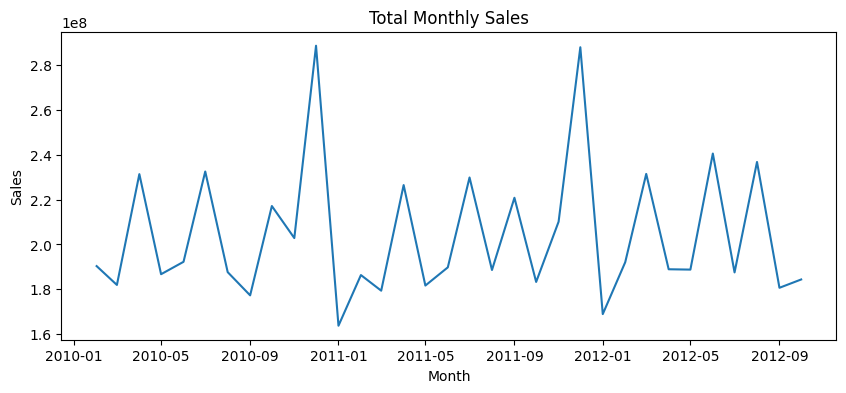

In [5]:
#  Plot total monthly sales
plt.figure(figsize=(10,4))
plt.plot(monthly_total.index, monthly_total["Sales"])
plt.title("Total Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()


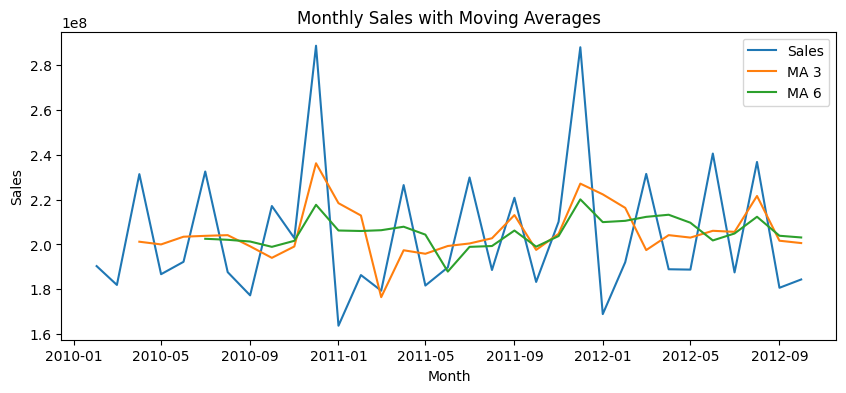

In [6]:
#  3 month and 6 month moving averages
monthly_total["MA_3"] = monthly_total["Sales"].rolling(3).mean()
monthly_total["MA_6"] = monthly_total["Sales"].rolling(6).mean()

plt.figure(figsize=(10,4))
plt.plot(monthly_total.index, monthly_total["Sales"], label="Sales")
plt.plot(monthly_total.index, monthly_total["MA_3"], label="MA 3")
plt.plot(monthly_total.index, monthly_total["MA_6"], label="MA 6")
plt.title("Monthly Sales with Moving Averages")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()


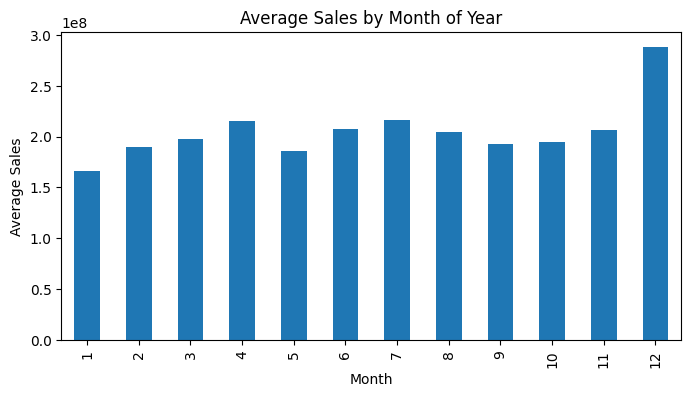

In [7]:
#  Simple seasonality by month of year
seasonality = (
    monthly_total.assign(Month=monthly_total.index.month)
                 .groupby("Month")["Sales"]
                 .mean()
)

ax = seasonality.plot(kind="bar", figsize=(8,4))
ax.set_title("Average Sales by Month of Year")
ax.set_xlabel("Month")
ax.set_ylabel("Average Sales")
plt.show()


**Breakdown by product and region over time**

Product = Dept
Region = Store Type (A, B, C)

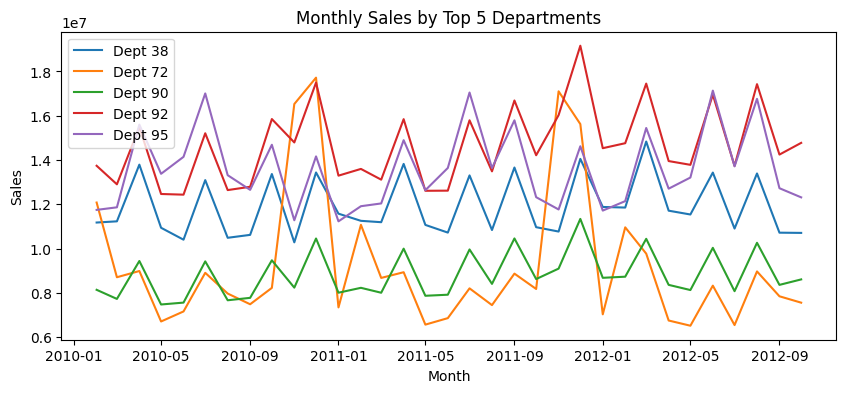

In [8]:
# a: Monthly by Dept (product)
dept_monthly = (
    df.set_index("Date")
      .groupby("Dept")
      .resample("MS")["Sales"]
      .sum()
      .reset_index()
)

# Pick top N departments by total sales
topN = 5
top_depts = (
    dept_monthly.groupby("Dept")["Sales"].sum()
    .sort_values(ascending=False)
    .head(topN)
    .index
)

dept_pivot = (
    dept_monthly[dept_monthly["Dept"].isin(top_depts)]
    .pivot(index="Date", columns="Dept", values="Sales")
    .fillna(0.0)
)

plt.figure(figsize=(10,4))
for c in dept_pivot.columns:
    plt.plot(dept_pivot.index, dept_pivot[c], label=f"Dept {c}")
plt.title(f"Monthly Sales by Top {topN} Departments")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()


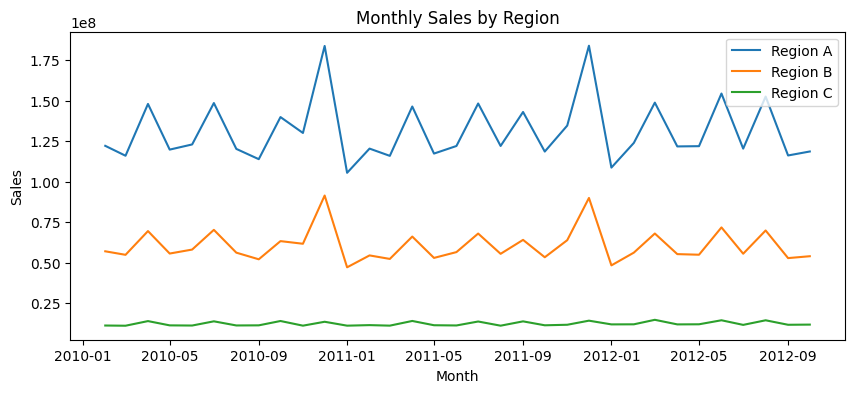

In [9]:
# b: Monthly by Region (store type A B C)
region_monthly = (
    df.set_index("Date")
      .groupby("Region")
      .resample("MS")["Sales"]
      .sum()
      .reset_index()
)

region_pivot = region_monthly.pivot(index="Date", columns="Region", values="Sales").fillna(0.0)

plt.figure(figsize=(10,4))
for c in region_pivot.columns:
    plt.plot(region_pivot.index, region_pivot[c], label=f"Region {c}")
plt.title("Monthly Sales by Region")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()


**Simple forecasting**

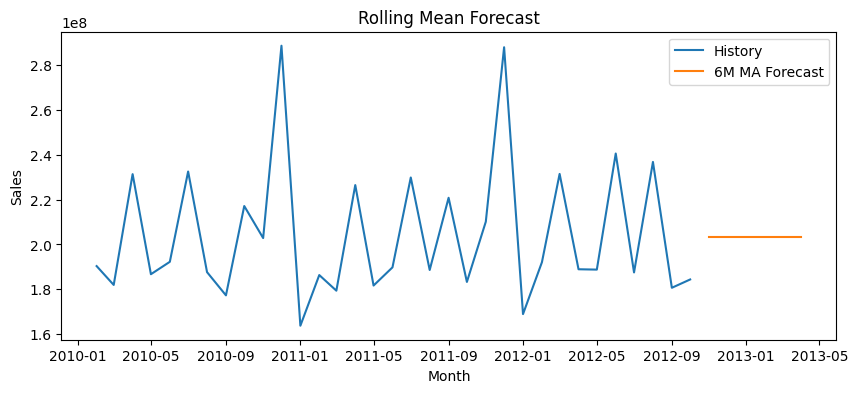

In [10]:
#  a: Rolling mean forecast for next 6 months
h = 6  # forecast horizon in months
ma_window = 6

ts = monthly_total["Sales"].copy()
last_ma = ts.rolling(ma_window).mean().iloc[-1]

future_idx = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=h, freq="MS")
ma_forecast = pd.Series([last_ma]*h, index=future_idx, name="MA_Forecast")

plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.values, label="History")
plt.plot(ma_forecast.index, ma_forecast.values, label=f"{ma_window}M MA Forecast")
plt.title("Rolling Mean Forecast")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()


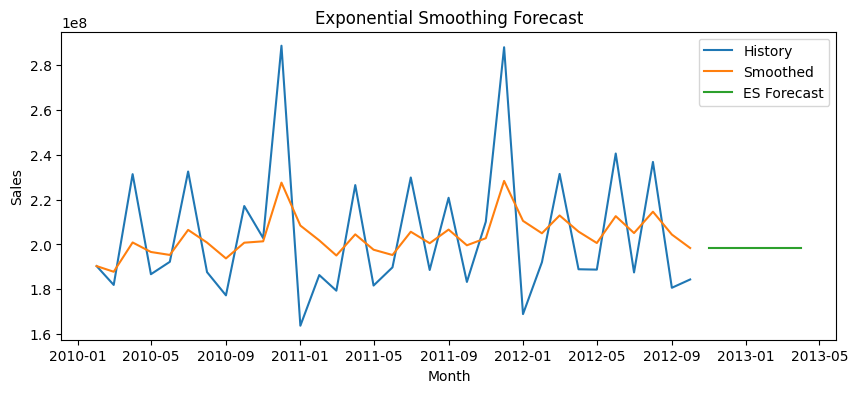

In [12]:
# b: Exponential smoothing forecast for next 6 months
alpha = 0.3  # smoothing factor
smoothed = ts.ewm(alpha=alpha, adjust=False).mean()
last_smooth = smoothed.iloc[-1]

es_forecast = pd.Series([last_smooth]*h, index=future_idx, name="ES_Forecast")

plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.values, label="History")
plt.plot(smoothed.index, smoothed.values, label="Smoothed")
plt.plot(es_forecast.index, es_forecast.values, label="ES Forecast")
plt.title("Exponential Smoothing Forecast")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()


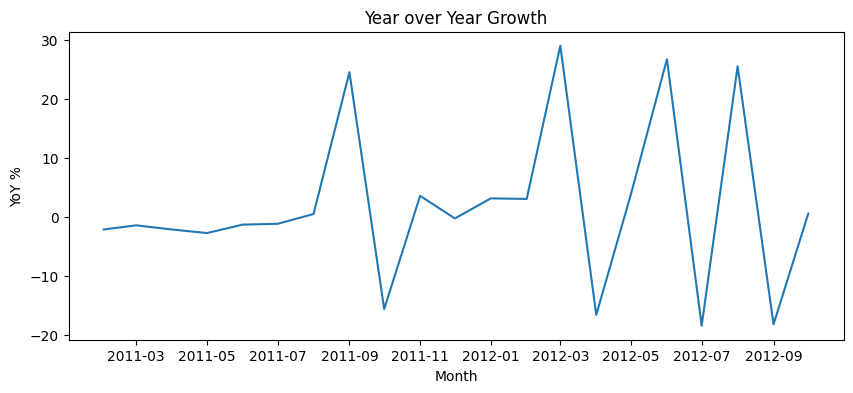

In [13]:
# YoY growth by month
monthly_total["Sales_LastYear"] = monthly_total["Sales"].shift(12)
monthly_total["YoY_%"] = (monthly_total["Sales"] - monthly_total["Sales_LastYear"]) / monthly_total["Sales_LastYear"] * 100

plt.figure(figsize=(10,4))
plt.plot(monthly_total.index, monthly_total["YoY_%"])
plt.title("Year over Year Growth")
plt.xlabel("Month")
plt.ylabel("YoY %")
plt.show()
